In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas as pd
import json

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Rappel du sujet

- 15 actifs min et 40 max
- chaque actif ne doit pas etre superieux a 10% du portefeuille

# Manager API

In [3]:

class RESTManager:
    HOST_NAME = "dolphin.jump-technology.com"
    PORT = "8443"

    URL = "https://" + HOST_NAME + ":" + PORT + "/api/v1/"

    USERNAME_USER1 = "EPITA_GROUPE8"
    PASSWORD_USER1 = "AgLyQx64Jw6pAkW9"

    auth = (USERNAME_USER1, PASSWORD_USER1)


    def get(self, path):
        return requests.get(self.URL+path, auth=self.auth, verify=False).text
    
    def put(self, path, data):
        return requests.put(self.URL+path, auth=self.auth, data=data, verify=False)
    
    def post(self, path, data):
        return requests.post(self.URL+path, auth=self.auth, data=data, verify=False)
    
    def get_asset(self):
        dt_text = self.get("asset?columns=ASSET_DATABASE_ID&columns=LABEL&columns=TYPE&columns=LAST_CLOSE_VALUE_IN_CURR&columns=CURRENCY&date=2016-06-01")
        dt = json.loads(dt_text)
        df = []
        for i in range(len(dt)):
            tmp = {}
            for key in dt[i]:
                tmp[key] = dt[i][key]["value"]
            df.append(tmp)
        df = pd.DataFrame(df)
        return df
    
    def get_asset_id(self, uid):
        dt_text = self.get(f"asset/{uid}")
        dt = json.loads(dt_text)
        df={}
        for key in dt:
            df[key] = dt[key]["value"]
        #df = pd.DataFrame(df)
        return df
    
    def get_asset_id_quote(self, uid):
        dt_text = self.get(f"asset/{uid}/quote")
        dt = json.loads(dt_text)
        df = []
        for i in range(len(dt)):
            tmp = {}
            for key in dt[i]:
                tmp[key] = dt[i][key]["value"]
            df.append(tmp)
        df = pd.DataFrame(df)
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
        #l = ["ask" ,"asset" ,"bid" ,"close" ,"feed_source" ,"gross" ,"high" ,"low","nav" ,"open", "pl" ,"real_close_price" ,"return" ,"volume"]
        l = ["return","nav"]
        for elt in l:
            df[elt] = df[elt].str.replace(',', '.').astype(float)
        return df
    
    def get_ratio(self):
        self.get("ratio")
    
    def sharpe(self, df, taux_sans_risque, periode=30):
        df['Log_Ret'] = np.log(df['close'] / df['close'].shift(1))
        df['Volatility'] = df['Log_Ret'].rolling(window=periode).std() * np.sqrt(periode)
        sharpe = (df["return"] - taux_sans_risque["1 mois"])/df["Volatility"]
        return sharpe
    
    def get_portfolio(self):
        resp = self.get("portfolio/1827/dyn_amount_compo")
        return resp

    def push(self, data):
        return self.put("portfolio/1827/dyn_amount_compo", data)
    
    def get_ratios(self, ref=False):
        data = {
            "ratio": [9, 12, 10],
            "asset": [1827, 2201],
            "start_date": "2016-06-01",
            "end_date": "2020-09-30",
            "frequency": "daily"
        }
        return self.post("ratio/invoke", json.dumps(data)).text
    
    def change_currency(self, c_in, c_out):
        url = f"currency/rate/{c_in}/to/{c_out}?date=2016-06-01"
        js = json.loads(self.get(url))["rate"]["value"].replace(",", ".")
        return float(js)
        

req = RESTManager()

In [4]:
df_asset = req.get_asset()
df_asset

,ASSET_DATABASE_ID,CURRENCY,LABEL,LAST_CLOSE_VALUE_IN_CURR,TYPE
0,1845,EUR,1&1 DRILLISCH AG,"36,851 EUR",STOCK
1,1846,EUR,1000MERCIS,"40,9 EUR",STOCK
2,2122,EUR,1818-VEGA EUR CO,"39,37 EUR",FUND
3,2123,EUR,29 HAUSSMANN CROISSANCE EUROPE D,"1670,65 EUR",FUND
4,2124,EUR,29 HAUSSMANN EQUILIBRE,NaN,FUND
5,1428,EUR,AAA - ACTIONS AGRO ALIM.I FCP,NaN,FUND
6,1847,EUR,AALBERTS INDS,"31,7 EUR",STOCK
7,1848,EUR,AAREAL BANK AG,"32,81 EUR",STOCK
8,1849,EUR,ABC ARBITRAGE,"6,73 EUR",STOCK
9,2154,USD,ABERDEEN CHINA EQUITY A2,"20,9896 USD",FUND


# Optimisation de portefeuille

In [5]:
def sharpe(w,mat_return):
    mat_cov = np.cov(mat_return)# * mat_return.shape[1]


    if w.ndim != 1:
        variance = []
        for i in range(w.shape[0]):
            variance.append(w[i] @ mat_cov @ w[i].T)
    else:
        variance = w @ mat_cov @ w.T
        
    variance = np.array(variance)
    std = np.sqrt(variance)
    average_rend = mat_return.mean(axis=1)
    
    return (variance, std, average_rend@w.T)


# rendement & volatilité

Commençons par calculer la volatilité et le rendement de chaque actif pour pouvoir etablir un classement.

## 1) Récuperation des rendements

In [6]:
list_id = df_asset["ASSET_DATABASE_ID"].values
l_id = []

#Pour avoir l'index
a = req.get_asset_id_quote(list_id[0])[["return"]]
list_return = pd.DataFrame(index=a.index)
list_nav = pd.DataFrame(index=a.index)


for elt in list_id:
    if elt != "1827":
        try:
            df_tmp = req.get_asset_id_quote(elt)
            list_return[elt] = df_tmp["return"]
            list_nav[elt] = df_tmp["nav"]
            l_id.append(elt)
        except:
            pass
l_id = np.array(l_id)
list_nav = list_nav.fillna(method='ffill')

In [7]:
print(l_id.shape)
print(list_return.shape)

(472,)
(1898, 472)


on veut le rendement sur 2016-06-01 jusqu'a 2020-09-30

In [8]:
import datetime as dt
start = dt.datetime.strptime('2016-06-01', '%Y-%m-%d')
end = dt.datetime.strptime('2020-09-30', '%Y-%m-%d')
sdf = (list_return.index > start) & (list_return.index < end)

l_return = list_return.loc[sdf]
l_return = l_return.fillna(0)

## 2) Classement

In [9]:
rend_l = l_return.values.mean(axis=0)
std_l = l_return.values.std(axis=0)
rend_l.shape

(472,)

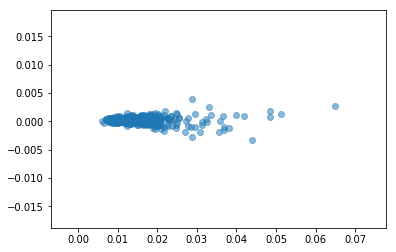

In [10]:
plt.scatter(std_l,rend_l, alpha=0.5)

Lors du classement on va favoriser les rendements a la volatilité

In [11]:
sort_rend = np.argsort(rend_l)
sort_std = np.argsort(std_l)

#classement
classement = np.zeros_like(sort_rend)
for i in range(len(sort_rend)):
    classement[sort_rend[i]] += i*30
    classement[sort_std[len(sort_rend)-1-i]] += i

## 3) Methode Naive (n=2)

Notre premiere approche est une methode dit "Brute force".  
En effet, nous allons essayer toute les possibilités, pour a la fin recupérer celle avec
la volatilité la plus faible.

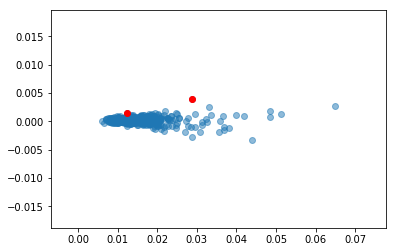

In [12]:
# on récupere les Deux meilleur
res = np.argsort(classement)[-2:]

plt.scatter(std_l,rend_l, alpha=0.5)
plt.scatter(std_l[res],rend_l[res], c="red")

rend: -0.0004465991983778891 & volatilité: 0.01247222437089075 -> poid: [0.36363636 0.63636364]


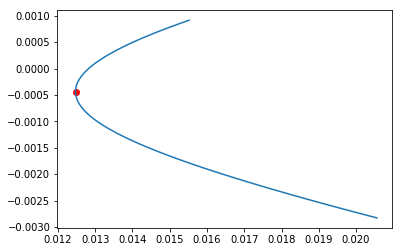

In [13]:
#On créé une matrice avec les rendements de chaque actif en column
mat_return = np.array(l_return.values[res])
mat_return = np.nan_to_num(mat_return)

#On va faire une list de tout les w possible
w = np.linspace(0, 1, num=100)
W = np.array([w, 1-w]).T

variance, std, rend = sharpe(W, mat_return)

#On récupere le minimum de volatilité
minimum = np.argmin(std)
print(f"rend: {rend[minimum]} & volatilité: {std[minimum]} -> poid: {W[minimum]}")

plt.plot(std,rend)
plt.scatter(std[minimum], rend[minimum], c="red")

## Methode Naive à 3 actifs (n=3) 

[112 298 199]


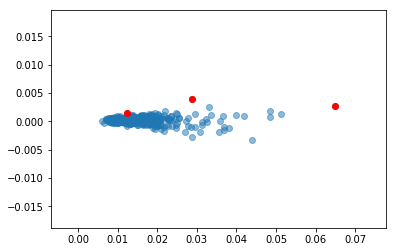

In [14]:
import itertools

w = np.linspace(0, 1, num=100)

n_w = np.array(list(itertools.permutations(w, 3)))

n_w = n_w[np.sum(n_w,axis=1) == 1]

res = np.argsort(classement)[-3:]
print(res)

plt.scatter(std_l,rend_l, alpha=0.5)
plt.scatter(std_l[res],rend_l[res], c="red")

In [15]:
mat_return = np.array(l_return.values[res])
mat_return = np.nan_to_num(mat_return)

variance, std, rend = sharpe(n_w, mat_return)

rend: 0.003307973502525167 & volatilité: 0.010300211492216297 -> poid: [0.29292929 0.26262626 0.44444444]


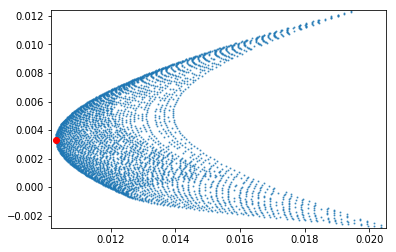

In [16]:
minimum = np.argmin(std)

print(f"rend: {rend[minimum]} & volatilité: {std[minimum]} -> poid: {n_w[minimum]}")

plt.margins(x=0, y=-0.01)
plt.scatter(std,rend,s=1, alpha=0.7)
plt.scatter(std[minimum], rend[minimum], c="red")

# Optimization (minimal var) [avec Resolution analytique]

In [17]:
res = np.argsort(classement)[-2:]
mat_return = np.array(l_return.values[res])


> https://www.ephiquant.com/optimisation-de-portefeuille-modele-mean-variance-de-markowitz/

on cherche a optimiser le programme quadratique suivant

$$ 
 \left\{
    \begin{array}{ll}
       Min \ \sigma^2_p(w) = w^T\sigma w \\
       w^Tu = 1
    \end{array}
\right.$$

on va utiliser la méthode du multiplicateur de Lagrange:

$$
\mathcal{L}(\omega,\lambda) = \omega^\top \sigma \omega - \lambda(\omega^\top u-1)
$$

> où $\lambda$ est le multiplicateur de Lagrange

Nous allons ensuite calculer les dérivées partielles que nous allons spécifier égales à 0 : 

$$
\begin{cases} \frac{\partial\mathcal{L}}{\omega}= 2\sigma\omega-\lambda u=0 \quad \text{(a)}\\  \frac{\partial\mathcal{L}}{\partial\lambda}=\omega^\top u-1=0 \quad\quad\text{(b)}\end{cases}
$$

Nous allons d’abord tirer $\omega$ dans l’équation (a), après quoi nous allons le remplacer dans l’équation (b) par son expression: 

$$
\begin{split} \text{(a)} \quad 2\sigma\omega-\lambda u=0\quad  \implies \omega &= \frac{1}{2}\lambda\sigma^{-1}u \\ \text{(b)} \quad \omega^\top u-1=0 \implies \omega^\top u &= 1 \\ \frac{1}{2}\lambda u^\top\sigma^{-1}u &=1 \\  \lambda &= \frac{2}{u^\top\sigma^{-1}u} \end{split}
$$

Nous allons mettre cette dernière expression de $\lambda$ dans l’expression de $\omega$. Cela donnera ceci : 

$$
\begin{equation*}\omega=\frac{1}{2} \bigg(\frac{2}{u^{\top}\sigma^{-1}u} \bigg) \sigma^{-1}u \implies \omega=\frac{\sigma^{-1}u}{u^\top\sigma^{-1}u} \end{equation*}
$$

In [18]:
# u = [1, ..., 1]

In [19]:
r = rend_l[res]
u = np.ones(r.shape[0])

sigma = np.cov(mat_return)
sigma_inv = np.linalg.inv(sigma) 

w = (sigma_inv @ u) / (u.T @ sigma_inv @ u)
w

array([0.36105675, 0.63894325])

rend: -0.0004465991983778891 & volatilité: 0.01247222437089075 -> poid: [0.36363636 0.63636364]
rend: -0.0004369427732414565 & volatilité: 0.01247204980519934 -> poid: [0.36105675 0.63894325]


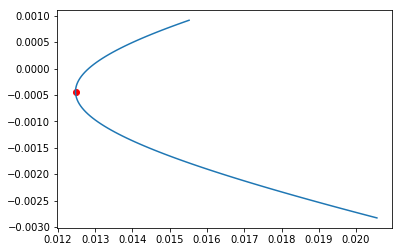

In [20]:
w_ = np.linspace(0, 1, num=100)
W = np.array([w_, 1-w_]).T

variance, std, rend = sharpe(W, mat_return)
minimum = np.argmin(std)
print(f"rend: {rend[minimum]} & volatilité: {std[minimum]} -> poid: {W[minimum]}")

plt.plot(std,rend)

variance, std, rend = sharpe(w, mat_return)
plt.scatter(std, rend, c="red")
print(f"rend: {rend} & volatilité: {std} -> poid: {w}")

## resolution analytique avec les 15 meilleurs actifs

In [21]:
res = np.argsort(classement)[-15:]
r = rend_l[res]
u = np.ones(r.shape[0])
mat_return = np.array(l_return.values[res])

sigma = np.cov(mat_return)

sigma_inv = np.linalg.inv(sigma) 

w = (sigma_inv @ u) / (u.T @ sigma_inv @ u)

w

array([0.11409408, 0.04122997, 0.08851583, 0.06739106, 0.04124986,
       0.11305451, 0.12803129, 0.04863073, 0.01108649, 0.05458294,
       0.03439904, 0.09094654, 0.04951367, 0.0183365 , 0.09893749])

In [22]:
variance, std, rend = sharpe(w, mat_return)
print(f"rend: {rend} & volatilité: {std} \n -> poid: {w}")

rend: 0.0026683773943286834 & volatilité: 0.004393268101614537 
 -> poid: [0.11409408 0.04122997 0.08851583 0.06739106 0.04124986 0.11305451
 0.12803129 0.04863073 0.01108649 0.05458294 0.03439904 0.09094654
 0.04951367 0.0183365  0.09893749]


## Benchmark

Regardons l'influence du nombre d'actif sur le rendement et la volatilité.

[2] rend: -0.0004369427732414565 & volatilité: 0.01247204980519934
[3] rend: 0.003367652777146972 & volatilité: 0.01029928910267818
[4] rend: 0.0035259702482595637 & volatilité: 0.008324506342767189
[5] rend: 0.003051527610881727 & volatilité: 0.008085443144501386
[6] rend: 0.0035378697852437575 & volatilité: 0.007212088834941763
[7] rend: 0.0036305010163024186 & volatilité: 0.006819057627645176
[8] rend: 0.004124423187347633 & volatilité: 0.006187060628671193
[9] rend: 0.0037238858405736885 & volatilité: 0.005644612595226033
[10] rend: 0.0032948769822232784 & volatilité: 0.005282003362432458
[11] rend: 0.003634499730351129 & volatilité: 0.0051917672983101655
[12] rend: 0.0031529611851744536 & volatilité: 0.004975765608848374
[13] rend: 0.0032955083359279555 & volatilité: 0.004808176275335639
[14] rend: 0.003124527561786953 & volatilité: 0.0047468057911323955
[15] rend: 0.0026683773943286834 & volatilité: 0.004393268101614537
[16] rend: 0.0023886697873949534 & volatilité: 0.00398826619

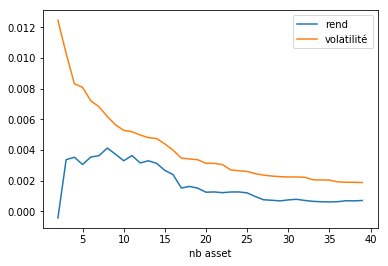

In [23]:
hist = []
for i in range(2,40,1):
    res = np.argsort(classement)[-i:]
    r = rend_l[res]
    u = np.ones(r.shape[0])
    mat_return = np.array(l_return.values[res])

    sigma = np.cov(mat_return)
    sigma_inv = np.linalg.inv(sigma) 

    w = (sigma_inv @ u) / (u.T @ sigma_inv @ u)
    variance, std, rend = sharpe(w, mat_return)
    print(f"[{i}] rend: {rend} & volatilité: {std}")
    hist.append([rend, std])

hist = np.array(hist)

plt.plot(range(2,40,1),hist[:,0], label="rend")
plt.plot(range(2,40,1),hist[:,1], label="volatilité")
plt.xlabel("nb asset")
plt.legend()

## Optimisation avec rendement fixé

In [24]:
res = np.argsort(classement)[-2:]
r = rend_l[res]
u = np.ones(r.shape[0])
mat_return = np.array(l_return.values[res])

sigma = np.cov(mat_return)
sigma_inv = np.linalg.inv(sigma) 

$$
\begin{equation*}\omega=E\mu_0+F\end{equation*}
$$

avec:

$$
E=\frac{1}{D}\sigma^{-1}(C\mu-Au)\quad \text{et} \quad F=\frac{1}{D}\sigma^{-1}(-A\mu+Bu)
$$


Nous allons définir 
- $A=u^\top\sigma^{-1}\mu=\mu^\top\sigma^{-1}u$ 
- $B=\mu^\top\sigma^{-1}\mu$ 
- $C=u^\top\sigma^{-1}u$
- $D=BC-A^2$

In [25]:
A = u.T @ sigma_inv @ r 
B = r.T @ sigma_inv @ r
C = u.T @ sigma_inv @ u
D = B*C - (A**2)

In [26]:
E = (1/D) * sigma_inv @ (C*r - A*u)
F = (1/D) * sigma_inv @ (-A*r + B*u)

w = E* 0.004 + F
w

array([0.99733108, 0.00266892])

In [27]:
variance, std, rend = sharpe(w, mat_return)
print(f"[{i}] rend: {rend} & volatilité: {std}")

[39] rend: -0.002818750582300833 & volatilité: 0.02050535048138912


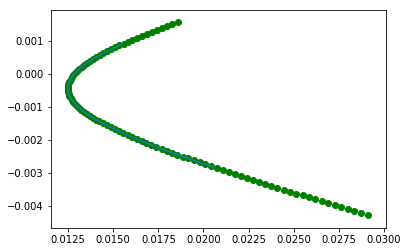

In [28]:
w_ = np.linspace(0, 1, num=100)
W = np.array([w_, 1-w_]).T


variance, std, rend = sharpe(W, mat_return)

minimum = np.argmin(std)
plt.plot(std,rend)

target_ = np.linspace(0.001, 0.005, num=100)
best = ""

for i in target_:
    w = E* i + F
    variance, std, rend = sharpe(w, mat_return)
    if std < rend:
        best = f"rend: {rend} & volatilité: {std}"
        plt.scatter(std, rend, c="red")
    else:
        plt.scatter(std, rend, c="green")
        
print(best)

En Rouge: rendement > risque  
En Vert : rendement < risque

## N=15

In [29]:
res = np.argsort(classement)[-15:]
mat_return = np.array(l_return.values[res])

In [30]:
def get_w(mat_return, u_t= 0.0017):
    r = mat_return.mean(axis=1)
    u = np.ones(r.shape[0])
    
    sigma = np.cov(mat_return)
    sigma_inv = np.linalg.inv(sigma) 
    
    A = u.T @ sigma_inv @ r 
    B = r.T @ sigma_inv @ r
    C = u.T @ sigma_inv @ u
    D = B*C - (A**2)
    
    E = (1/D) * sigma_inv @ (C*r - A*u)
    F = (1/D) * sigma_inv @ (-A*r + B*u)

    w = E* u_t + F
    return w


w_20 = get_w(mat_return, 0.003)
print(w_20)
sharpe(w_20, mat_return)

[0.10778586 0.03592542 0.09242703 0.059778   0.05087698 0.10393058
 0.12372796 0.05545009 0.01622113 0.06122143 0.03035973 0.09290658
 0.05520379 0.01533894 0.09884648]


(array(1.94306916e-05), 0.004408025817746978, 0.0029999999999999996)

In [31]:
def checking_w(w):
    if np.sum(w<0) == 0:
        if np.sum((w >= 0.01) & (w <= 0.1)) == w.shape[0]:
            return True
    return False

checking_w(np.array([0.2, 0.05]))

False

15 0
16 0
17 0
0.00312, 0.003123123123123123
0.00315, 0.003153153153153153
0.00318, 0.0031831831831831835
0.00321, 0.0032132132132132135
0.00324, 0.003243243243243244
0.00327, 0.003273273273273273
0.0033, 0.0033033033033033035
0.00333, 0.003333333333333333
0.00336, 0.0033633633633633636
0.00339, 0.003393393393393394
0.00342, 0.0034234234234234236
0.00345, 0.003453453453453453
0.00348, 0.003483483483483484
0.00351, 0.003513513513513514
0.00354, 0.003543543543543544
0.00357, 0.0035735735735735736
18 0
19 0
0.00282, 0.002822822822822823
0.00285, 0.002852852852852853
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
rend: 0.0035735735735735736 & volatilité: 0.004001461561152136


array([0.08500627, 0.09482719, 0.06558617, 0.01028997, 0.08541323,
       0.03119926, 0.09368603, 0.04700034, 0.08094881, 0.06588834,
       0.02301538, 0.07647376, 0.01617005, 0.08377057, 0.05743828,
       0.01323873, 0.0700476 ])

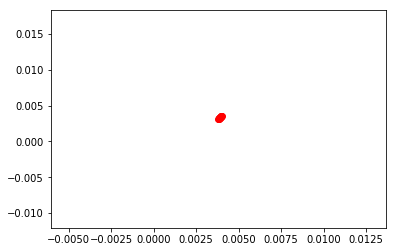

In [47]:
res = np.argsort(classement)[-15:]
mat_return = np.array(l_return.values[res])
target_ = np.linspace(0.000, 0.03, num=1000)
best = ""
W=np.array([])
actual_rend = 0
actual_std = 1
decal = 0
Res=[]

while len(W) == 0 and decal < 20:
    for j in range(15,40):
        print(j, decal)
        if decal > 0:
            res = np.argsort(classement)[-j-decal:-decal]
        else:
            res = np.argsort(classement)[-j:]
        mat_return = np.array(l_return.values[res])
        for i in target_:
            w = get_w(mat_return, i)
            if checking_w(w):
                variance, std, rend = sharpe(w, mat_return)
                print(f"{i:0.3}, {rend}")
                if actual_rend/actual_std < rend/std:
                    Res=res
                    W=w
                    actual_rend= rend
                    actual_std = std
                    best = f"rend: {rend} & volatilité: {std}"
                    plt.scatter(std, rend, c="red")
    decal+=1
        
print(best)
W

## Verification

Notre porte-feuille doit respecter plusieurs criteres:

- 50% stock en prix
- check la currency
- check les lots
- 1% a 10% par actif


In [48]:
def check_type(list_id):
    #df_asset = req.get_asset()[["ASSET_DATABASE_ID", "TYPE"]]
    mask = df_asset['ASSET_DATABASE_ID'].isin(list_id)
    pf_type = df_asset.loc[mask]["TYPE"].values
    #print(np.unique(pf_type, return_counts=True))
    return pf_type
    
    
check_type(l_id[Res])

array(['FUND', 'STOCK', 'STOCK', 'STOCK', 'STOCK', 'STOCK', 'STOCK',
       'STOCK', 'STOCK', 'STOCK', 'STOCK', 'STOCK', 'STOCK', 'STOCK',
       'STOCK', 'STOCK', 'STOCK'], dtype=object)

In [49]:
def check_currency(list_id):
    mask = df_asset['ASSET_DATABASE_ID'].isin(list_id)
    pf_type = df_asset.loc[mask]["CURRENCY"].values
    return pf_type
    
    
check_currency(l_id[Res])

array(['USD', 'EUR', 'EUR', 'EUR', 'EUR', 'EUR', 'USD', 'EUR', 'EUR',
       'EUR', 'EUR', 'EUR', 'EUR', 'EUR', 'EUR', 'EUR', 'USD'],
      dtype=object)

In [50]:
req.change_currency("EUR","USD")

1.1174

In [51]:
def get_amout(w, list_id, list_nav, solde= 100000000):
    
    stock_price = 0
    global_price = 0
    actif_price = []
    
    #On recupere la list de type d'actif et leur currency
    l_currency = check_currency(list_id)
    l_type = check_type(list_id)
    
    #On prend les prix de l'actif a la date
    start = dt.datetime.strptime('2016-06-01', '%Y-%m-%d')
    price = list_nav.loc[list_nav.index == start]
    
    #Pour chaque actif on recupere le nombre que l'on peut en acheter
    # nombre = (solde*poid) / prix d'une action
    nb_actif= []
    for i in range(len(list_id)):
        unit_price = price[list_id[i]].values[0]
        if l_currency[i] != "EUR":
            r = req.change_currency(l_currency[i],"EUR")
            unit_price = r * unit_price
            
        nb = int((solde*w[i])//unit_price)
        
        if l_type[i] == "STOCK":
            stock_price+= nb*unit_price
        global_price += nb*unit_price
        
        nb_actif.append(nb)
        actif_price.append(nb*unit_price)
        
    actif_price = np.array(actif_price)
    print("% de chaque actif :",actif_price/global_price)
    print(f"Stock % :{(stock_price/global_price):0.2}")
    return np.array(nb_actif)
    
    
get_amout(W, l_id[Res], list_nav)

% de chaque actif : [0.08500603 0.09482735 0.06558639 0.01028995 0.08541351 0.03119933
 0.09368627 0.04700036 0.08094902 0.0658881  0.02301546 0.07647396
 0.0161701  0.08377082 0.05743848 0.01323804 0.07004683]
Stock % :0.91


array([   162396,    220528,   7495562,     52366,  94903589,    726408,
         1191630,    217091,    828544,    140756, 133810370,    952350,
         3850011,    399105,  95730474,     13238,     53628])

Nous verrifions si le montant de stock est bien superieur a 50%

In [52]:
def get_asset_pf(W, list_id, list_nav):
    nb = get_amout(W,list_id,list_nav)
    nb = np.nan_to_num(nb)
    ret = []
    for i in range(len(list_id)):
        js = {}
        js["asset"] = int(list_id[i])
        js["quantity"] = int(nb[i])
        ret.append({"asset": js})
    return ret

new_pt = get_asset_pf(W, l_id[Res], list_nav)
new_pt

% de chaque actif : [0.08500603 0.09482735 0.06558639 0.01028995 0.08541351 0.03119933
 0.09368627 0.04700036 0.08094902 0.0658881  0.02301546 0.07647396
 0.0161701  0.08377082 0.05743848 0.01323804 0.07004683]
Stock % :0.91


[{'asset': {'asset': 1872, 'quantity': 162396}},
 {'asset': {'asset': 1990, 'quantity': 220528}},
 {'asset': {'asset': 2035, 'quantity': 7495562}},
 {'asset': {'asset': 1912, 'quantity': 52366}},
 {'asset': {'asset': 1959, 'quantity': 94903589}},
 {'asset': {'asset': 1884, 'quantity': 726408}},
 {'asset': {'asset': 1877, 'quantity': 1191630}},
 {'asset': {'asset': 2058, 'quantity': 217091}},
 {'asset': {'asset': 1956, 'quantity': 828544}},
 {'asset': {'asset': 2112, 'quantity': 140756}},
 {'asset': {'asset': 2076, 'quantity': 133810370}},
 {'asset': {'asset': 2034, 'quantity': 952350}},
 {'asset': {'asset': 2023, 'quantity': 3850011}},
 {'asset': {'asset': 2154, 'quantity': 399105}},
 {'asset': {'asset': 1901, 'quantity': 95730474}},
 {'asset': {'asset': 2024, 'quantity': 13238}},
 {'asset': {'asset': 1958, 'quantity': 53628}}]

## Porte-Feuille

In [54]:
new_portfolio = {
    "label":"EPITA_PTF_8",
    "currency": {
        "code":"EUR"
    },
    "type":"front",
    "values": {
        "2016-06-01": new_pt
    }
}
pp = json.dumps(new_portfolio)

In [55]:
req.push(pp).text

''

In [56]:
portfolio = req.get_portfolio()
portfolio

'{"label":"EPITA_PTF_8","currency":{"code":"EUR"},"type":"front","values":{"2016-06-01":[{"asset":{"asset":2112,"quantity":140756.0}},{"asset":{"asset":1956,"quantity":828544.0}},{"asset":{"asset":1990,"quantity":220528.0}},{"asset":{"asset":1958,"quantity":53628.0}},{"asset":{"asset":1959,"quantity":9.4903589E7}},{"asset":{"asset":2023,"quantity":3850011.0}},{"asset":{"asset":2024,"quantity":13238.0}},{"asset":{"asset":2058,"quantity":217091.0}},{"asset":{"asset":2154,"quantity":399105.0}},{"asset":{"asset":1901,"quantity":9.5730474E7}},{"asset":{"asset":1872,"quantity":162396.0}},{"asset":{"asset":2034,"quantity":952350.0}},{"asset":{"asset":2035,"quantity":7495562.0}},{"asset":{"asset":1877,"quantity":1191630.0}},{"asset":{"asset":1912,"quantity":52366.0}},{"asset":{"asset":1884,"quantity":726408.0}},{"asset":{"asset":2076,"quantity":1.3381037E8}}]}}'

In [61]:
#9:r 10:v 12:sharpe
pd.DataFrame(json.loads(req.get_ratios()))

,2201,1827
10,"{'type': 'percent', 'value': '0,166459552501'}","{'type': 'percent', 'value': '0,140556818897'}"
12,"{'type': 'double', 'value': '0,146571943186'}","{'type': 'double', 'value': '2,752436418938'}"
9,"{'type': 'percent', 'value': '0,029398300072'}","{'type': 'percent', 'value': '0,391873707262'}"
